In [4]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
from qiskit.circuit.library import MCXGate, QFT, CPhaseGate, CRZGate
from walsh import *
#from sequential import *
from primitives import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

## Simulations

256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256


Text(0.5, 1.0, 'Diffusion equation resolution: 64,64')

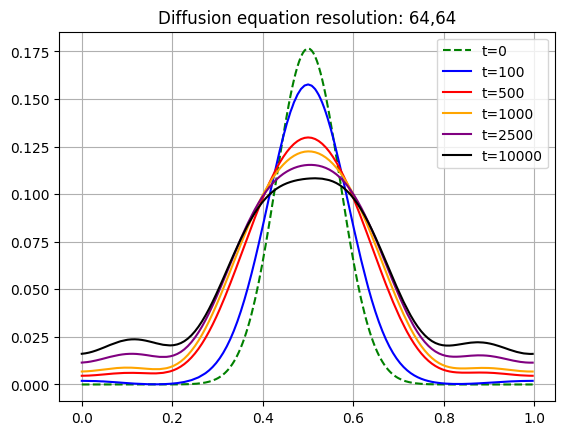

In [17]:
# QSP
'''
fig = plt.figure()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "font.size": 18
})
'''
def init(x):
    epsilon0 = 1/10
    return np.exp(-(x-0.5)**2*100)*epsilon0

n = 8
N = 2**n
n_ancilla_adjustable = 0
n_ancilla_qsp = 0
gray_code = False
swaps = True

X = np.array(range(2**n))/(2**n)
plt.plot(X,init(X)/np.linalg.norm(init(X)),marker='',c='g',linestyle='--',label='t=0')

n_walsh_qsp = 64

walsh_coeffs = {}
for i in range(2**n):
    walsh_coeffs[i] = abs(walsh_coeff(i,init,2**n))
w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
list_operator_to_implement_qsp = sorted(list(dict(w).keys())[:n_walsh_qsp])

n_walsh_non_unitary = 64

for c in range(5):
    t = [100,500,1000,2500,10000][c]
    color=['blue','red','orange','purple','black'][c]
        
    q = QuantumRegister(n,name='q')
    qA = QuantumRegister(1,name='qA')
    qB = QuantumRegister(1,name='qB')
    a = AncillaRegister(n_ancilla_adjustable,name='a')
    a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
    qc = QuantumCircuit(qB,qA,q,a,a_qsp)
    
    qB_qubits = qc.qubits[:1]
    qA_qubits = qc.qubits[1:2]
    q_qubits = qc.qubits[2:n+2]
    a_qubits = qc.qubits[n+2:n+2+n_ancilla_adjustable]
    a_qsp_qubits = qc.qubits[n+2+n_ancilla_adjustable:n+2+n_ancilla_adjustable+n+2+n_ancilla_qsp]
    
    old_qc_qubits = q_qubits+a_qubits
    
    for i in range(int(n/2)):
        qc.swap(q[i],q[n-i-1])   
    
    qc.h(q)
    
    qc.h(qA)
    # copy of qA
    copy_gate_qsp = copy(qA,a_qsp)
    qc.append(copy_gate_qsp,qA_qubits+a_qsp_qubits)
    
    # copy of main register
    if n_ancilla_adjustable >= n:
        copy_gate = copy(q,a)
        qc.append(copy_gate,q_qubits+a_qubits)
    
    
    n_blocks = get_n_blocks(n,n_ancilla_adjustable)
    n_rotations = len(list_operator_to_implement_qsp)
    n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
    walsh_info = walsh_informations(n,list_operator_to_implement_qsp,init,gray_code=gray_code)
    for i in range(0,n_blocks):
        walsh_info_block = dict(list(walsh_info.items())[:n_operator_per_block_list[i]])
        qc.append(walsh_circuit_qsp(n,n_ancilla_qsp,init,walsh_info_block,gray_code=gray_code),old_qc_qubits[i*n:(i+1)*n]+qA_qubits+a_qsp_qubits)
        walsh_info = dict(list(walsh_info.items())[n_operator_per_block_list[i]:])
        #qc.barrier()
    
    # undo copy of main register
    if n_ancilla_adjustable >= n:
        qc.append(copy_gate.inverse(),q_qubits+a_qubits)
    
    # undo copy of qA
    qc.append(copy_gate_qsp.inverse(),qA_qubits+a_qsp_qubits)
    
    qc.h(qA)
    qc.p(np.pi/2,qA)
    
    for i in range(int(n/2)):
        qc.swap(q[i],q[n-i-1])

    ### NON UNITARY PART
    
    # Non-unitary
    def get_dmax(d,N):
        maxi = 0
        for i in range(N):
            if abs(d(i/N)) > maxi:
                maxi = abs(d(i/N))
        return maxi

    def d(x):
        kappa = 1
        
        #return np.exp(-t*kappa*(np.sin(2*np.pi*x)+8*np.sin(4*np.pi*x))**2)
        #return np.exp(-t*kappa*(x-0.5)**2)
        return np.exp(-t*kappa*np.sin(2*np.pi*(x-0.5))**2)
        #return np.exp(-(x-0.5)**2)
    
    def f(x,d,dmax):
        return np.arccos(d(x)/(2*dmax))
     
    # QFT
    QFT_gate = QFT(n,do_swaps=False)
    qc.append(QFT_gate,q_qubits)
    
    qc.h(qB)
    #qc.h(q)
    
    # copy of qA
    copy_gate_qsp = copy(qB,a_qsp)
    qc.append(copy_gate_qsp,qB_qubits+a_qsp_qubits)
    
    # copy of main register
    if n_ancilla_adjustable >= n:
        copy_gate = copy(q,a)
        qc.append(copy_gate,q_qubits+a_qubits)
    
    walsh_coeffs = {}
    for i in range(2**n):
        walsh_coeffs[i] = abs(walsh_coeff(i,d,2**n))
    w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
    list_operator_to_implement_non_unitary = sorted(list(dict(w).keys())[:n_walsh_non_unitary])
    
    n_blocks = get_n_blocks(n,n_ancilla_adjustable)
    n_rotations = len(list_operator_to_implement_non_unitary)
    n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
    walsh_info = walsh_informations_non_unitary(n,list_operator_to_implement_non_unitary,f,d,gray_code=gray_code)
    for i in range(0,n_blocks):
        walsh_info_block = dict(list(walsh_info.items())[:n_operator_per_block_list[i]])
        qc.append(walsh_circuit_non_unitary(n,n_ancilla_qsp,f,walsh_info_block,gray_code=gray_code),old_qc_qubits[i*n:(i+1)*n]+qB_qubits+a_qsp_qubits)
        walsh_info = dict(list(walsh_info.items())[n_operator_per_block_list[i]:])
        #qc.barrier()
    
    # undo copy of main register
    if n_ancilla_adjustable >= n:
        qc.append(copy_gate.inverse(),q_qubits+a_qubits)
    
    # undo copy of qA
    qc.append(copy_gate_qsp.inverse(),qB_qubits+a_qsp_qubits)
    
    qc.h(qB)
    
    qc.append(QFT_gate.inverse(),q_qubits)
    
    
    dmax = get_dmax(d,2**n) #len(list_operator_to_implement_non_unitary)
    state = qi.Statevector.from_instruction(qc)
    state_dict = state.to_dict()
    data = []
    n_bits = len(list(state_dict.keys())[0])
    for i in list(state_dict.keys()):
        if i[n_bits-1] == '0' and i[n_bits-2] == '1':
            data.append(state_dict[i])
    L = np.array(data)
    plt.plot(X,np.real(L)/np.linalg.norm(L),marker='',linestyle='-',c=color,label='t='+str(t))
    
plt.legend()
plt.grid()
plt.title('Diffusion equation resolution: '+str(n_walsh_qsp)+','+str(n_walsh_non_unitary))